## Import Dataset

In [ ]:
!pip install prophet
!pip install opendatasets

In [ ]:
import opendatasets as od
import pandas as pd

# Download Walmart Sales dataset from Kaggle
od.download(
    "https://www.kaggle.com/datasets/mikhail1681/walmart-sales")

Skipping, found downloaded files in "./walmart-sales" (use force=True to force download)


In [ ]:
# Read in the downloaded dataset
file =('/content/walmart-sales/Walmart_Sales.csv')
raw_dataset = pd.read_csv(file)
raw_dataset.columns = raw_dataset.columns.str.replace(' ', '_').str.lower()
raw_dataset.head(10)

,store,date,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment
0,1,05-02-2010,1643691,0,42,3,211,8
1,1,12-02-2010,1641957,1,39,3,211,8
2,1,19-02-2010,1611968,0,40,3,211,8
3,1,26-02-2010,1409728,0,47,3,211,8
4,1,05-03-2010,1554807,0,46,3,211,8
5,1,12-03-2010,1439542,0,58,3,211,8
6,1,19-03-2010,1472516,0,55,3,211,8
7,1,26-03-2010,1404430,0,51,3,211,8
8,1,02-04-2010,1594968,0,62,3,211,8
9,1,09-04-2010,1545419,0,66,3,211,8


## Clean and Explore the Dataset

In [ ]:
# Check observation counts and datatypes
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   store         6435 non-null   int64  
 1   date          6435 non-null   object 
 2   weekly_sales  6435 non-null   float64
 3   holiday_flag  6435 non-null   int64  
 4   temperature   6435 non-null   float64
 5   fuel_price    6435 non-null   float64
 6   cpi           6435 non-null   float64
 7   unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [ ]:
# Format date column datatype
raw_dataset['date'] = pd.to_datetime(raw_dataset['date'], dayfirst=True)

In [ ]:
# Check for duplicates
raw_dataset.duplicated().sum()

0

In [ ]:
# Check for negative or $0 weekly_sales values
print((raw_dataset['weekly_sales'] < 0).any().any())
print((raw_dataset['weekly_sales'] == 0).any().any())

False
False


In [ ]:
# Check date range
min(raw_dataset['date']), max(raw_dataset['date'])

(Timestamp('2010-02-05 00:00:00'), Timestamp('2012-10-26 00:00:00'))

In [ ]:
# Check number of stores
raw_dataset['store'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

In [ ]:
import numpy as np

pd.set_option('display.float_format', lambda x: '%.f' %x)

## Find store with weekly sales closest to the overall mean of weekly sales

# Calculate the overall mean weekly sales across all stores
overall_mean = raw_dataset['weekly_sales'].mean()

# Calculate the mean weekly sales for each store + assign column for overall mean
store_means = raw_dataset.groupby('store')['weekly_sales'].mean().reset_index()
store_means['overall_mean'] = overall_mean

# Calculate absolute difference from the overall mean for each store
store_means['mean_diff'] = np.abs(store_means['weekly_sales'] - store_means['overall_mean'])

# Sort the DataFrame by the mean difference in ascending order
store_means_sorted = store_means.sort_values(by='mean_diff', ascending=True)
print(store_means_sorted.head())

    store  weekly_sales  overall_mean  mean_diff
21     22       1028501       1046965      18464
17     18       1084718       1046965      37754
11     12       1009002       1046965      37963
25     26       1002912       1046965      44053
33     34        966782       1046965      80183


In [ ]:
# Filter dataset to one store for initial forecasting
forecast_dataset = raw_dataset.loc[raw_dataset['store'] == 22]

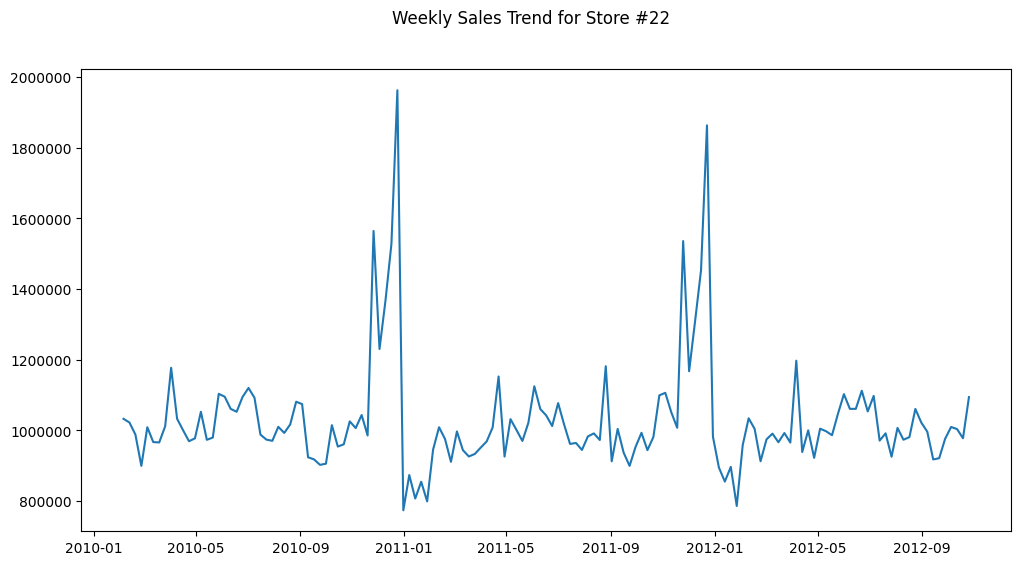

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Plot filtered dataset and view trend
plt.figure(figsize=(12, 6))
plt.plot(forecast_dataset['date'], forecast_dataset['weekly_sales'])

# Set the y-axis to use plain formatting (no exponents)
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.gca().ticklabel_format(style='plain', axis='y')

# Set title
plt.suptitle('Weekly Sales Trend for Store #22')
plt.show()


## Preprocess Data for Modelling

In [ ]:
# Split the data into training and testing sets + select model features
split_date = '2012-01-05'
model_features = ['date', 'weekly_sales', 'holiday_flag','temperature']

model_train = forecast_dataset[model_features].loc[forecast_dataset['date'] <= split_date].copy()
model_test = forecast_dataset[model_features].loc[forecast_dataset['date'] > split_date].copy()

# Rename columns for to fit model specifications
model_train = model_train.rename(columns={'date':'ds','weekly_sales':'y'})
model_test = model_test.rename(columns={'date':'ds','weekly_sales':'y'})

# Print out Train and Test details
print(model_train.shape)
print(model_test.shape)
print('\n')
print(f'training start date:',model_train['ds'].min())
print(f'training end date:',model_train['ds'].max())
print('\n')
print(f'test start date:',model_test['ds'].min())
print(f'test end date:',model_test['ds'].max())


(100, 4)
(43, 4)


training start date: 2010-02-05 00:00:00
training end date: 2011-12-30 00:00:00


test start date: 2012-01-06 00:00:00
test end date: 2012-10-26 00:00:00


## Build Model

In [ ]:
from prophet import Prophet

# Initialize the Prophet model
model = Prophet(
        yearly_seasonality=True,
    seasonality_mode='multiplicative'
)

# Add the holiday_flag and temperature as regressors
model.add_regressor('holiday_flag')
model.add_regressor('temperature')

# Fit the model on the training data
model.fit(model_train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj_rike46/kpysg94k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj_rike46/rrgb9nj9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3535', 'data', 'file=/tmp/tmpj_rike46/kpysg94k.json', 'init=/tmp/tmpj_rike46/rrgb9nj9.json', 'output', 'file=/tmp/tmpj_rike46/prophet_model7nv10doz/prophet_model-20240811181958.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:19:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## Evaluate Model

In [ ]:
# Make predictions on the test data
forecast = model.predict(model_test)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,extra_regressors_multiplicative,extra_regressors_multiplicative_lower,extra_regressors_multiplicative_upper,holiday_flag,...,temperature,temperature_lower,temperature_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2012-01-06,1019198,757966,1046215,1019198,1019198,0,0,0,0,...,0,0,0,-0,-0,-0,0,0,0,896853
1,2012-01-13,1018912,542371,835034,1018912,1018912,0,0,0,0,...,0,0,0,-0,-0,-0,0,0,0,696508
2,2012-01-20,1018625,557459,845771,1018625,1018625,0,0,0,0,...,0,0,0,-0,-0,-0,0,0,0,704030
3,2012-01-27,1018339,692762,993288,1018339,1018339,0,0,0,0,...,0,0,0,-0,-0,-0,0,0,0,843434
4,2012-02-03,1018052,818382,1107285,1018052,1018052,0,0,0,0,...,0,0,0,-0,-0,-0,0,0,0,967448


/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


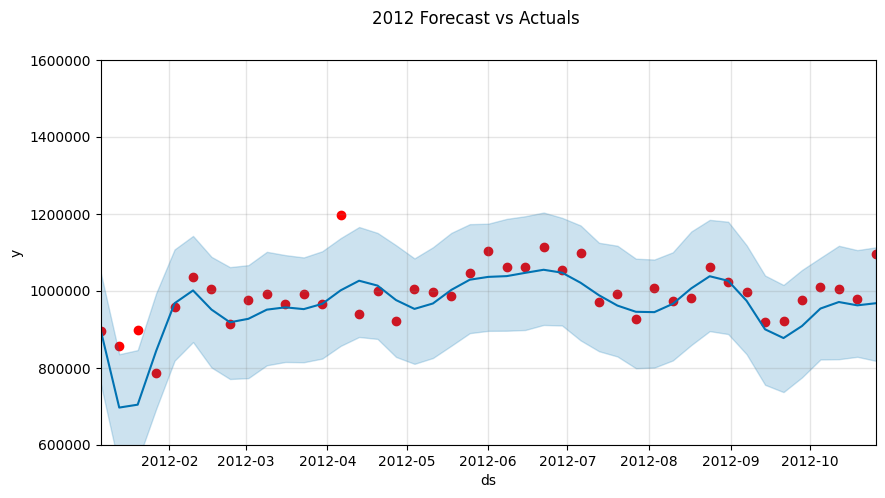

In [ ]:
# Convert 'ds' column to datetime
model_test['ds'] = pd.to_datetime(model_test['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the actual data points from the test set + forecast from the Prophet model
ax.scatter(model_test['ds'], model_test['y'], color='r', label='Actual')
model.plot(forecast, ax=ax)

# Set the x and y axis limits
ax.set_xlim(pd.to_datetime('2012-01-06'), pd.to_datetime('2012-10-26'))
ax.set_ylim(600000, 1600000)

# Set the y-axis to use plain formatting (no exponents)
ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
ax.ticklabel_format(style='plain', axis='y')

# Set a title for the plot
plt.suptitle('2012 Forecast vs Actuals')
plt.show()

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` o

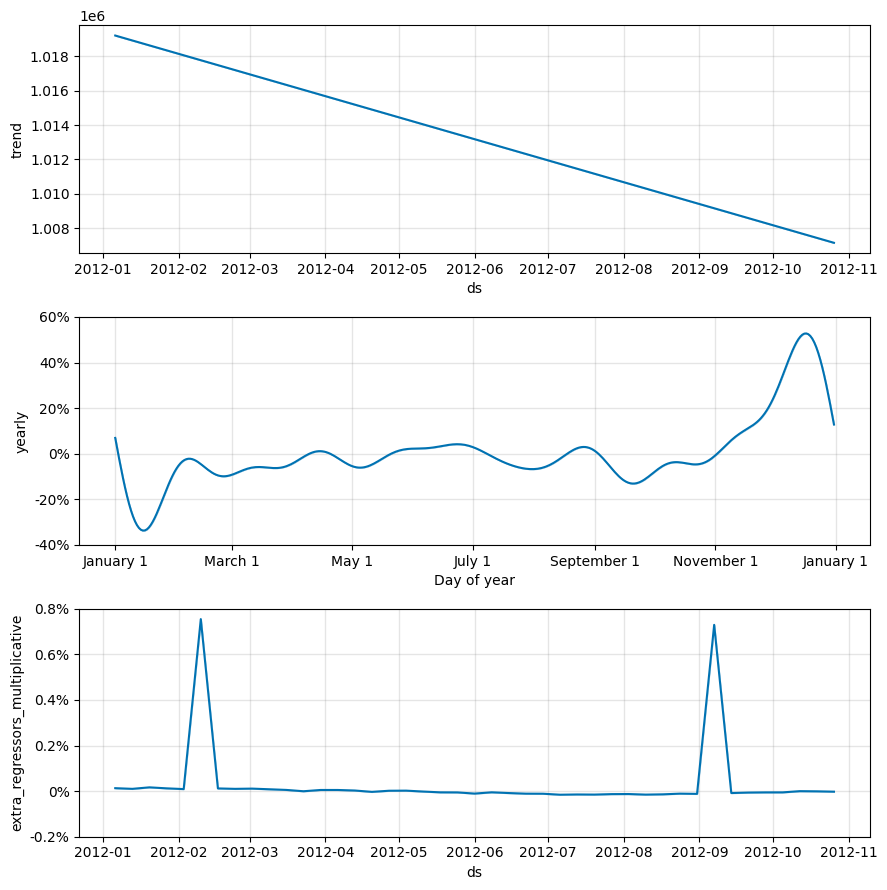

In [ ]:
# Show model component effects
fig = model.plot_components(forecast)
plt.show()

In [ ]:
# Define function for MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Display model performance metrics
mae = mean_absolute_error(y_true=model_test['y'], y_pred=forecast['yhat'])
rmse = np.sqrt(mean_squared_error(y_true=model_test['y'], y_pred=forecast['yhat']))
mape = mean_absolute_percentage_error(y_true=model_test['y'], y_pred=forecast['yhat'])
print(f'Mean Absolute Error: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'Mape: {mape:.2f}')

Mean Absolute Error: 45127.23
RMSE: 64428.33
Mape: 4.56
